<a href="https://colab.research.google.com/github/ipavlopoulos/paremia/blob/main/clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Loading the texts

In [2]:
# proverbs = pd.read_csv("https://raw.githubusercontent.com/ipavlopoulos/paremia/main/data/balanced_corpus.csv", index_col=0)
proverbs = pd.read_csv('data/balanced_corpus.csv')
proverbs.columns

Index(['Unnamed: 0', 'text', 'place', 'uri', 'collector', 'area', 'lat',
       'lon'],
      dtype='object')

### Representing the texts with TFIDF

In [3]:
proverbs['num_words'] = proverbs['text'].str.split().apply(len)

num_words_counts = proverbs['num_words'].value_counts().sort_index()
num_words_counts

num_words
1       22
2      265
3      617
4     1173
5     1351
6     1392
7     1536
8     1462
9     1186
10     886
11     502
12     295
13     175
14     111
15     112
16     117
17      75
18      58
19      63
20      21
21      26
22      13
23       8
24      10
25       6
26       1
27       5
28       2
29       1
30       3
31       1
33       2
36       1
39       1
77       1
Name: count, dtype: int64

<Axes: xlabel='num_words'>

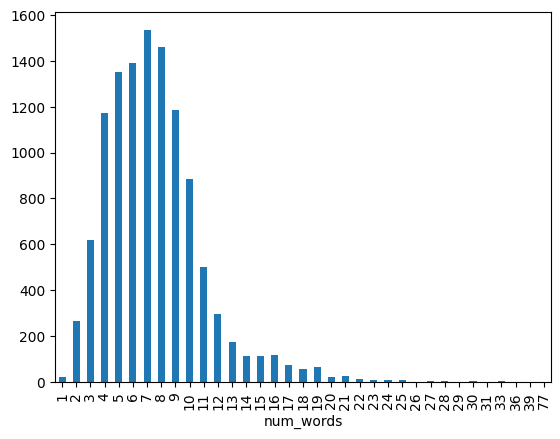

In [4]:
num_words_counts.plot.bar()

In [5]:
proverbs[proverbs['num_words'] > 30]['text']

1540    Κείνος που δούλευε ακριβά πεινούσε , και κείνο...
3586    Τη Δευτέρα πάει στο μύλο και την Τρίτη πάει το...
3668    Εψές πέθαν' ο άντρας μου, προχτές ο γάϊδαρός μ...
3987    Στους πέντε μήνες το σκυλλι στο ξάμηνο τ' αδρά...
4898    Κάηκα, μάννα μ, κάηκα! Μ' κάηκες για, παιδί μ,...
9964    Τ' 'αη Γιωργιού ύφαινενε μια το πανάκι ντου κα...
Name: text, dtype: object

In [6]:
proverbs = proverbs[proverbs['num_words'] > 1]
proverbs

,Unnamed: 0,text,place,uri,collector,area,lat,lon,num_words
0,105697,Γέλια σαν κομπολόγια,"Ήπειρος, Ζαγόρι, Βίτσα",http://hdl.handle.net/20.500.11853/168435,"Σάρρος, Δημήτριος Μ.",Ήπειρος,37.998253,23.737867,3
1,8413,Καρδίαν καθαράν θέλ' ο Θεός,Ήπειρος,http://hdl.handle.net/20.500.11853/167032,"Γόνιος, Α.",Ήπειρος,37.998253,23.737867,5
2,7684,Ου Θεός κι ου γείτονας,Ήπειρος,http://hdl.handle.net/20.500.11853/168991,"Γαλδέμης, Αναστάσιος Δ.",Ήπειρος,37.998253,23.737867,5
3,18546,Θέλει να κρυφθή πίσω από το δάχτυλό του,Ήπειρος,http://hdl.handle.net/20.500.11853/273352,"Ζηκίδης, Γεώργιος Δ.",Ήπειρος,37.998253,23.737867,8
4,94001,Όλοι κλαίν' τα χάλια τ'ς κι ο μυλωνάς τη δέσι,Ήπειρος,http://hdl.handle.net/20.500.11853/204755,"Παπαγεωργίου, Ιωάννης",Ήπειρος,37.998253,23.737867,10
...,...,...,...,...,...,...,...,...,...
11495,101735,Παστρζικό τσανα τσ' έναι!,Σκύρος,http://hdl.handle.net/20.500.11853/247609,"Περδίκα, Νίκη Λ.",Σκύρος,38.873044,24.524477,4
11496,101233,"Κάλλιο γεναίκα κάμισσα, πέρζι πολυπροικούσα",Σκύρος,http://hdl.handle.net/20.500.11853/195541,"Περδίκα, Νίκη Λ.",Σκύρος,38.873044,24.524477,5
11497,101612,Όγοιος κάθεται στη στερζά τσαί θάλασσα γερεύει...,Σκύρος,http://hdl.handle.net/20.500.11853/195683,"Περδίκα, Νίκη Λ.",Σκύρος,38.873044,24.524477,15
11498,101762,Πήε στ' δαιμόνου τ' μάννα,Σκύρος,http://hdl.handle.net/20.500.11853/195537,"Περδίκα, Νίκη Λ.",Σκύρος,38.873044,24.524477,5


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(ngram_range=(2, 5),
                       analyzer="char",
                       max_df=0.5,
                       min_df=2, lowercase=True)
X = vect.fit_transform(proverbs.text.values)

### Clustering for different number of clusters

In [8]:
# adjusted from https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#quantifying-the-quality-of-clustering-results

from collections import defaultdict
from time import time

from sklearn import metrics

evaluations = []
evaluations_std = []

def fit_and_evaluate(km, X, labels, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores["Inertia"].append(km.inertia_)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels,
                                                               km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels,
                                                                 km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

In [ ]:
from sklearn.cluster import KMeans
kappas = list(range(10, 30+1))
models = {}
for k in kappas:
    print(f'{k} clusters')
    fit_and_evaluate(KMeans(n_clusters=k, n_init='auto'),
                     X,
                     proverbs.area,
                     name=f"KMeans({k})")
    print()

10 clusters
clustering done in 0.77 ± 0.13 s 
Inertia: 11165.441 ± 3.259
Homogeneity: 0.020 ± 0.001
Completeness: 0.031 ± 0.002
V-measure: 0.024 ± 0.002
Adjusted Rand-Index: 0.004 ± 0.001
Silhouette Coefficient: 0.003 ± 0.000

11 clusters
clustering done in 0.90 ± 0.12 s 
Inertia: 11153.107 ± 4.199
Homogeneity: 0.020 ± 0.001
Completeness: 0.031 ± 0.002
V-measure: 0.024 ± 0.002
Adjusted Rand-Index: 0.004 ± 0.001
Silhouette Coefficient: 0.003 ± 0.000

12 clusters
clustering done in 1.47 ± 0.68 s 
Inertia: 11142.158 ± 4.006
Homogeneity: 0.021 ± 0.001
Completeness: 0.030 ± 0.002
V-measure: 0.025 ± 0.002
Adjusted Rand-Index: 0.004 ± 0.001
Silhouette Coefficient: 0.003 ± 0.000

13 clusters
clustering done in 1.28 ± 0.31 s 
Inertia: 11130.013 ± 6.449
Homogeneity: 0.023 ± 0.002
Completeness: 0.033 ± 0.002
V-measure: 0.027 ± 0.002
Adjusted Rand-Index: 0.005 ± 0.000
Silhouette Coefficient: 0.003 ± 0.000

14 clusters
clustering done in 1.08 ± 0.19 s 
Inertia: 11118.449 ± 5.578
Homogeneity: 0.025 

### Assessing the clusterings

In [ ]:
from kneed import KneeLocator

squared_distances = [ evaluation['Inertia'] for evaluation in evaluations ]
kl = KneeLocator(kappas, squared_distances, curve="convex",
                 direction="decreasing")

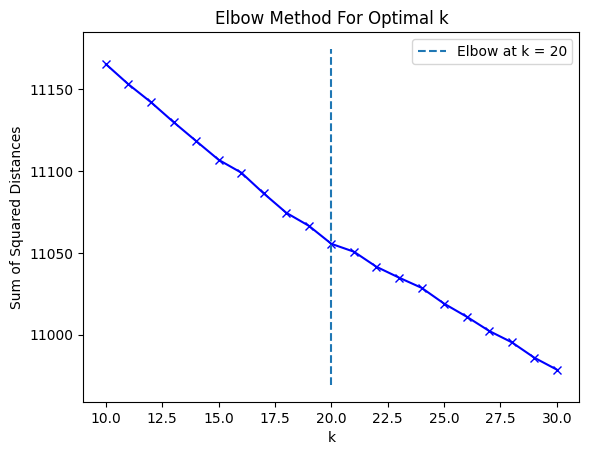

In [ ]:
plt.plot(kappas, squared_distances, 'bx-')
plt.vlines(kl.elbow, plt.ylim()[0], plt.ylim()[1], linestyles='dashed',
           label='Elbow at k = %d' % kl.elbow)
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.legend()
plt.show()

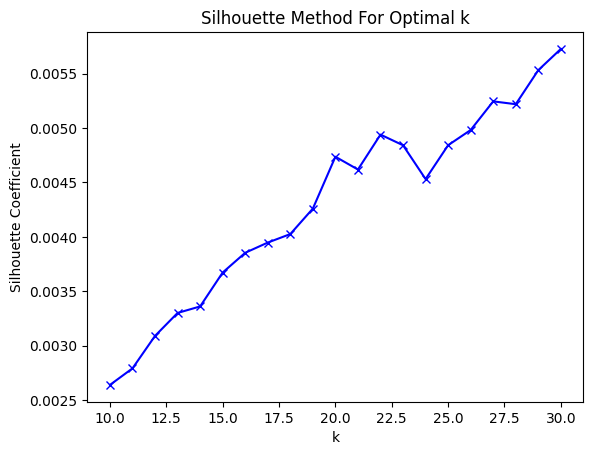

In [ ]:
silhouette_scores = [ evaluation['Silhouette Coefficient']
                     for evaluation in evaluations ]

plt.plot(kappas, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette Method For Optimal k')
plt.show()

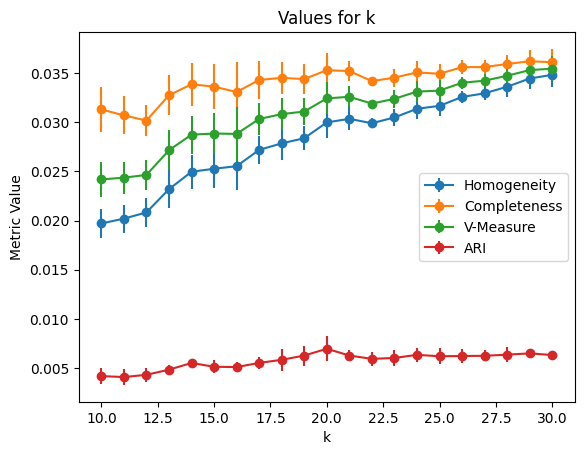

In [ ]:
homogeneity = [
               evaluation['Homogeneity']
               for evaluation in evaluations
]

homogeneity_std = [
                   evaluation['Homogeneity']
                   for evaluation in evaluations_std
]

completeness = [
                evaluation['Completeness']
                for evaluation in evaluations
]

completeness_std = [
                    evaluation['Completeness']
                    for evaluation in evaluations_std
]

v_measure = [
              evaluation['V-measure']
              for evaluation in evaluations
]

v_measure_std = [
                 evaluation['V-measure']
                 for evaluation in evaluations_std
]

ari = [
    evaluation['Adjusted Rand-Index']
    for evaluation in evaluations
]

ari_std = [
    evaluation['Adjusted Rand-Index']
    for evaluation in evaluations_std
]

plt.errorbar(kappas, homogeneity, yerr=homogeneity_std, fmt='-o',
             label='Homogeneity')
plt.errorbar(kappas, completeness, yerr=completeness_std, fmt='-o',
             label='Completeness')
plt.errorbar(kappas, v_measure, yerr=v_measure_std, fmt='-o',
             label='V-Measure')
plt.errorbar(kappas, ari, yerr=ari_std, fmt='-o',
             label='ARI')
plt.xlabel('k')
plt.ylabel('Metric Value')
plt.title('Values for k')
plt.legend()
plt.show()


# Assessing the 20Means Clustering

In [6]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=20, n_init='auto')
kmeans.fit(X)

KMeans(n_clusters=20, n_init='auto')

In [9]:
# saving the cluster assignments
proverbs['clustering'] = kmeans.labels_

The cluster 18 seems to work as a super cluster

In [12]:
proverbs[proverbs.area=='Ήπειρος'].clustering.value_counts()[:3]

18    154
11     41
14     32
Name: clustering, dtype: int64

In [24]:
proverbs[proverbs.area=='Κρήτη'].clustering.value_counts()[:3]

18    110
19     68
14     31
Name: clustering, dtype: int64

In [21]:
proverbs[proverbs.area=='Πόντος'].clustering.value_counts()[:3]

18    221
14     46
19     43
Name: clustering, dtype: int64

# Affinity Propagation

In [69]:
proverbs.text

0                                     Γέλια σαν κομπολόγια
1                              Καρδίαν καθαράν θέλ' ο Θεός
2                                   Ου Θεός κι ου γείτονας
3                  Θέλει να κρυφθή πίσω από το δάχτυλό του
4            Όλοι κλαίν' τα χάλια τ'ς κι ο μυλωνάς τη δέσι
                               ...                        
11495                            Παστρζικό τσανα τσ' έναι!
11496          Κάλλιο γεναίκα κάμισσα, πέρζι πολυπροικούσα
11497    Όγοιος κάθεται στη στερζά τσαί θάλασσα γερεύει...
11498                            Πήε στ' δαιμόνου τ' μάννα
11499                     Θα σε κάνου να κατουρζήσεις αίμα
Name: text, Length: 11478, dtype: object

In [92]:
proverbs.area.unique()

array(['Ήπειρος', 'Αιτωλία', 'Αμοργός', 'Ανατολική Θράκη', 'Αρκαδία',
       'Αχαΐα', 'Επτάνησος', 'Εύβοια', 'Θεσπρωτία', 'Θράκη', 'Ιωάννινα',
       'Κάρπαθος', 'Κεφαλληνία', 'Κρήτη', 'Κύπρος', 'Λέσβος', 'Λακωνία',
       'Μακεδονία', 'Μικρά Ασία', 'Νάξος', 'Πόντος', 'Ρόδος', 'Σκύρος'],
      dtype=object)

In [70]:
import Levenshtein

In [71]:
n_proverbs = len(proverbs)
affinity_matrix = np.zeros((n_proverbs, n_proverbs))
for i, proverb_i in enumerate(proverbs['text']):
    for j, proverb_j in enumerate(proverbs['text'][i:]):
        affinity = -Levenshtein.distance(proverb_i, proverb_j)
        affinity_matrix[i, j+i] = affinity
        affinity_matrix[j+i, i] = affinity

affinity_matrix


array([[  0., -21., -20., ..., -80., -21., -25.],
       [-21.,   0., -22., ..., -77., -22., -26.],
       [-20., -22.,   0., ..., -79., -19., -24.],
       ...,
       [-80., -77., -79., ...,   0., -75., -74.],
       [-21., -22., -19., ..., -75.,   0., -25.],
       [-25., -26., -24., ..., -74., -25.,   0.]])

In [15]:
from sklearn.cluster import AffinityPropagation

In [73]:
af = AffinityPropagation(affinity='precomputed', 
                         max_iter=500,    
                         verbose=True)
af.fit(affinity_matrix) 

Did not converge


AffinityPropagation(affinity='precomputed', max_iter=500, verbose=True)

In [93]:
vect = TfidfVectorizer(ngram_range=(1, 3),
                       analyzer="char",
                       max_df=0.5,
                       min_df=2, 
                       norm=None,
                       lowercase=True)
X = vect.fit_transform(proverbs.text.values)
X.shape

(11478, 10605)

In [94]:
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, linear_kernel

similarity = linear_kernel(X)

affinity_matrix = -similarity
affinity_matrix

array([[ -642.63180636,   -52.27724967,    -5.99811816, ...,
          -87.84352558,    -4.4067342 ,   -16.57748038],
       [  -52.27724967, -1106.9669376 ,  -170.41497388, ...,
         -115.19509052,   -27.42434642,   -55.64059213],
       [   -5.99811816,  -170.41497388,  -647.50250212, ...,
         -272.38556825,   -33.07317414,   -54.01470713],
       ...,
       [  -87.84352558,  -115.19509052,  -272.38556825, ...,
        -4139.84651389,  -332.11309969,  -265.92238059],
       [   -4.4067342 ,   -27.42434642,   -33.07317414, ...,
         -332.11309969, -1024.34244851,   -72.45588288],
       [  -16.57748038,   -55.64059213,   -54.01470713, ...,
         -265.92238059,   -72.45588288, -1086.01199127]])

In [84]:
similarity = cosine_similarity(X)

affinity_matrix = -similarity
affinity_matrix

array([[-1.        , -0.02713487, -0.        , ..., -0.01250951,
        -0.00161161, -0.00575512],
       [-0.02713487, -1.        , -0.0848973 , ..., -0.00990445,
        -0.00527754, -0.01055404],
       [-0.        , -0.0848973 , -1.        , ..., -0.05674994,
        -0.012666  , -0.01649822],
       ...,
       [-0.01250951, -0.00990445, -0.05674994, ..., -1.        ,
        -0.07196575, -0.03621004],
       [-0.00161161, -0.00527754, -0.012666  , ..., -0.07196575,
        -1.        , -0.02956321],
       [-0.00575512, -0.01055404, -0.01649822, ..., -0.03621004,
        -0.02956321, -1.        ]])

In [102]:
af = AffinityPropagation(affinity='precomputed',
                         max_iter=500,    
                         verbose=True)
labels = af.fit_predict(affinity_matrix)

Converged after 27 iterations.


In [103]:
cluster_centers_indices = af.cluster_centers_indices_
len(cluster_centers_indices)

20

In [104]:
cluster_centers_indices

array([  388,   567,   989,  1770,  2291,  2593,  3008,  3240,  4072,
        4794,  6629,  7576,  7577,  8556,  8800,  8850,  9142, 10305,
       10602, 11059])

In [105]:
cluster_centers = proverbs['text'][cluster_centers_indices]

In [106]:
cluster_centers

388                                            Πήρι δρόμον
567                                           Αυτός κάθετι
989                             Ξυέτι κει π΄ δε τουν τρώει
1770           Όσο πίν' η Μαργιωρίτσα, τόσο διπλοχαιρετάει
2291                           Αυτό είναι αγιοβασιλειάτικο
2593       Όμορφο παιδί στην κούνια άσκημο παιδί στη ρούγα
3008                Θέλει ο βασιλιάς και τον ορίζουν άλλοι
3240               Τα μοσκάτα η αλουπού θαν τα κατοφεγγίση
4072               Τα χρήματα και τα κρίματα δεν κρύβονται
4794                                 Ο λύκος ζητεί αντάραν
6629        Οντέ δειπνάς και δε με δης, καθάρια λίγωσή 'νε
7576     Σαρανταπέντε Γιάννηδες ενός κοκκόρου γνώσ' κι ...
7577        Σα διψά γι' αυλή σ', να μη χύν'ς του νιρό έξου
8556               Δούλεψ' το καλοκαίρι, να χ΄ς το χειμώνα
8800     Όλο τον κόσμο ρώτα κ' από τον νου σου μη βγαίνεις
8850                 Θκό τ' ψουμί, κι ξένου γκαϊλέ τραβάει
9142                        Σκάβει μόνος του τον λάκκο τ

In [107]:
proverbs.loc[cluster_centers_indices][['text', 'area']]

,text,area
388,Πήρι δρόμον,Ήπειρος
567,Αυτός κάθετι,Αιτωλία
989,Ξυέτι κει π΄ δε τουν τρώει,Αιτωλία
1770,"Όσο πίν' η Μαργιωρίτσα, τόσο διπλοχαιρετάει",Ανατολική Θράκη
2291,Αυτό είναι αγιοβασιλειάτικο,Αρκαδία
2593,Όμορφο παιδί στην κούνια άσκημο παιδί στη ρούγα,Αχαΐα
3008,Θέλει ο βασιλιάς και τον ορίζουν άλλοι,Επτάνησος
3240,Τα μοσκάτα η αλουπού θαν τα κατοφεγγίση,Επτάνησος
4072,Τα χρήματα και τα κρίματα δεν κρύβονται,Θεσπρωτία
4794,Ο λύκος ζητεί αντάραν,Θράκη


In [109]:
labels

array([ 8, 16,  4, ...,  5,  7, 16])

In [108]:
from sklearn.metrics import confusion_matrix

confusion_matrix(proverbs.area, labels)

ValueError: Mix of label input types (string and number)

In [11]:
from transformers import BertModel, BertTokenizer

model_name = 'nlpaueb/bert-base-greek-uncased-v1'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

In [9]:
import torch 

encoded_input = tokenizer(proverbs['text'].tolist(),
                          padding=True, 
                          truncation=True, 
                          return_tensors="pt", 
                          max_length=proverbs['num_words'].max())

In [12]:
with torch.no_grad():
    # Forward pass through the model
    outputs = model(**encoded_input)
    # Get the embeddings from the last hidden state
    # Shape: [batch_size, sequence_length, hidden_size]
    embeddings = outputs.last_hidden_state

embeddings.shape

In [13]:
embeddings.shape

torch.Size([11478, 77, 768])

In [14]:
proverb_embeddings = embeddings.mean(dim=1)
proverb_embeddings.shape

torch.Size([11478, 768])

In [16]:
af = AffinityPropagation(max_iter=500,    
                         verbose=True)
af.fit(proverb_embeddings) 

Converged after 124 iterations.


AffinityPropagation(max_iter=500, verbose=True)

In [17]:
cluster_centers_indices = af.cluster_centers_indices_
len(cluster_centers_indices)

679

In [25]:
from sklearn.cluster import KMeans
kappas = list(range(10, 30+1))
models = {}
for k in kappas:
    print(f'{k} clusters')
    fit_and_evaluate(KMeans(n_clusters=k, n_init='auto'),
                     proverb_embeddings,
                     proverbs.area,
                     name=f"KMeans({k})")
    print()

10 clusters
clustering done in 0.68 ± 0.12 s 
Inertia: 1097369.264 ± 279.903
Homogeneity: 0.032 ± 0.001
Completeness: 0.045 ± 0.002
V-measure: 0.038 ± 0.002
Adjusted Rand-Index: 0.013 ± 0.000
Silhouette Coefficient: 0.004 ± 0.003

11 clusters
clustering done in 0.61 ± 0.08 s 
Inertia: 1093448.586 ± 433.939
Homogeneity: 0.033 ± 0.002
Completeness: 0.044 ± 0.002
V-measure: 0.038 ± 0.002
Adjusted Rand-Index: 0.013 ± 0.001
Silhouette Coefficient: 0.003 ± 0.003

12 clusters
clustering done in 0.58 ± 0.14 s 
Inertia: 1089664.118 ± 765.426
Homogeneity: 0.034 ± 0.001
Completeness: 0.044 ± 0.002
V-measure: 0.039 ± 0.002
Adjusted Rand-Index: 0.013 ± 0.001
Silhouette Coefficient: 0.002 ± 0.002

13 clusters
clustering done in 0.58 ± 0.04 s 
Inertia: 1086038.937 ± 646.779
Homogeneity: 0.035 ± 0.002
Completeness: 0.044 ± 0.002
V-measure: 0.039 ± 0.002
Adjusted Rand-Index: 0.013 ± 0.001
Silhouette Coefficient: 0.001 ± 0.001

14 clusters
clustering done in 0.56 ± 0.07 s 
Inertia: 1082696.615 ± 635.521

In [26]:
from kneed import KneeLocator

squared_distances = [ evaluation['Inertia'] for evaluation in evaluations ]
kl = KneeLocator(kappas, squared_distances, curve="convex",
                 direction="decreasing")

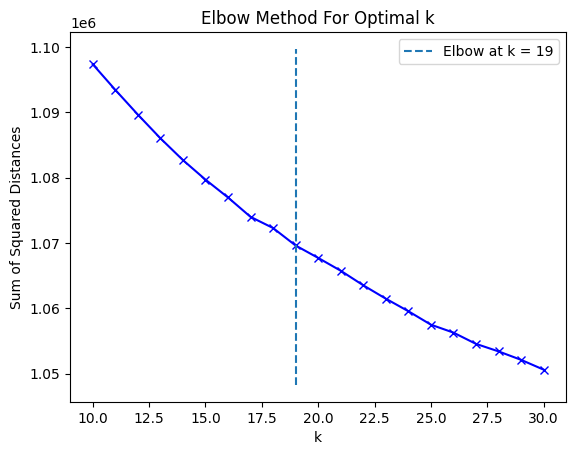

In [27]:
plt.plot(kappas, squared_distances, 'bx-')
plt.vlines(kl.elbow, plt.ylim()[0], plt.ylim()[1], linestyles='dashed',
           label='Elbow at k = %d' % kl.elbow)
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.legend()
plt.show()

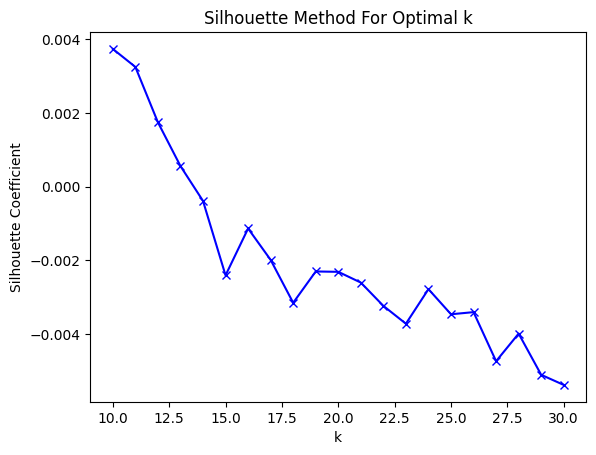

In [28]:
silhouette_scores = [ evaluation['Silhouette Coefficient']
                     for evaluation in evaluations ]

plt.plot(kappas, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette Method For Optimal k')
plt.show()

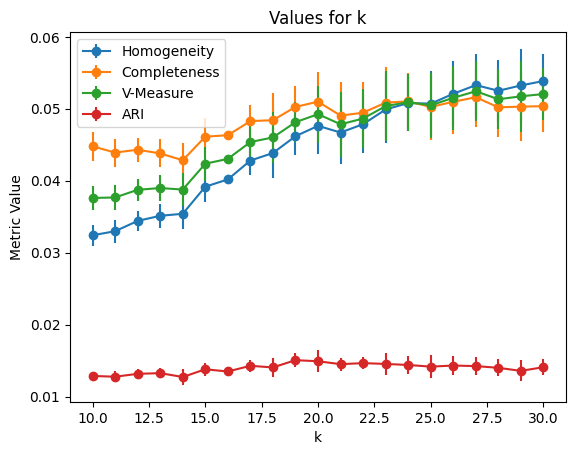

In [29]:
homogeneity = [
               evaluation['Homogeneity']
               for evaluation in evaluations
]

homogeneity_std = [
                   evaluation['Homogeneity']
                   for evaluation in evaluations_std
]

completeness = [
                evaluation['Completeness']
                for evaluation in evaluations
]

completeness_std = [
                    evaluation['Completeness']
                    for evaluation in evaluations_std
]

v_measure = [
              evaluation['V-measure']
              for evaluation in evaluations
]

v_measure_std = [
                 evaluation['V-measure']
                 for evaluation in evaluations_std
]

ari = [
    evaluation['Adjusted Rand-Index']
    for evaluation in evaluations
]

ari_std = [
    evaluation['Adjusted Rand-Index']
    for evaluation in evaluations_std
]

plt.errorbar(kappas, homogeneity, yerr=homogeneity_std, fmt='-o',
             label='Homogeneity')
plt.errorbar(kappas, completeness, yerr=completeness_std, fmt='-o',
             label='Completeness')
plt.errorbar(kappas, v_measure, yerr=v_measure_std, fmt='-o',
             label='V-Measure')
plt.errorbar(kappas, ari, yerr=ari_std, fmt='-o',
             label='ARI')
plt.xlabel('k')
plt.ylabel('Metric Value')
plt.title('Values for k')
plt.legend()
plt.show()

In [67]:
X_ex = np.array([[1, 2], [1, 4], [1, 0],
                 [4, 2], [4, 4], [4, 0]])
clustering = AffinityPropagation(random_state=5).fit(X_ex)

In [68]:
clustering.affinity_matrix_

array([[ -9.,  -4.,  -4.,  -9., -13., -13.],
       [ -4.,  -9., -16., -13.,  -9., -25.],
       [ -4., -16.,  -9., -13., -25.,  -9.],
       [ -9., -13., -13.,  -9.,  -4.,  -4.],
       [-13.,  -9., -25.,  -4.,  -9., -16.],
       [-13., -25.,  -9.,  -4., -16.,  -9.]])

In [69]:
af.affinity_matrix_

array([[0.98932837, 0.97286513, 1.        , ..., 0.98749049, 0.99838839,
        0.99424488],
       [0.97286513, 0.98932837, 0.9151027 , ..., 0.99009555, 0.99472246,
        0.98944596],
       [1.        , 0.9151027 , 0.98932837, ..., 0.94325006, 0.987334  ,
        0.98350178],
       ...,
       [0.98749049, 0.99009555, 0.94325006, ..., 0.98932837, 0.92803425,
        0.96378996],
       [0.99838839, 0.99472246, 0.987334  , ..., 0.92803425, 0.98932837,
        0.97043679],
       [0.99424488, 0.98944596, 0.98350178, ..., 0.96378996, 0.97043679,
        0.98932837]])

In [76]:
from sklearn.metrics.pairwise import euclidean_distances

dist = euclidean_distances(X_ex, X_ex)**2
dist

array([[ 0.,  4.,  4.,  9., 13., 13.],
       [ 4.,  0., 16., 13.,  9., 25.],
       [ 4., 16.,  0., 13., 25.,  9.],
       [ 9., 13., 13.,  0.,  4.,  4.],
       [13.,  9., 25.,  4.,  0., 16.],
       [13., 25.,  9.,  4., 16.,  0.]])

In [77]:
clustering = AffinityPropagation(random_state=5, affinity='precomputed').fit(-dist)

In [78]:
clustering.affinity_matrix_

array([[ -9.,  -4.,  -4.,  -9., -13., -13.],
       [ -4.,  -9., -16., -13.,  -9., -25.],
       [ -4., -16.,  -9., -13., -25.,  -9.],
       [ -9., -13., -13.,  -9.,  -4.,  -4.],
       [-13.,  -9., -25.,  -4.,  -9., -16.],
       [-13., -25.,  -9.,  -4., -16.,  -9.]])

In [82]:
X_ex[clustering.cluster_centers_indices_]

array([[1, 2],
       [4, 2]])